In [132]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.annotations.rename(dict(T1="hands", T2="feet"))
events = events_from_annotations(raw)
# Apply band-pass filter
raw.filter(7.0, 42.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    event_id=[2, 3],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=0.0, tmax=4.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from C:\Users\Vinícius\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Vinícius\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Vinícius\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'feet', 'hands']
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 42 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


Computing rank from data with rank=None


    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: ra

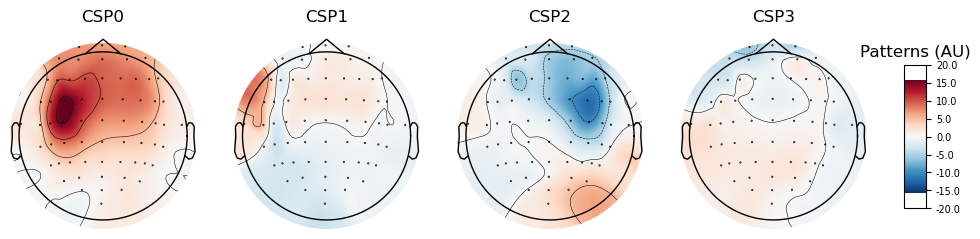

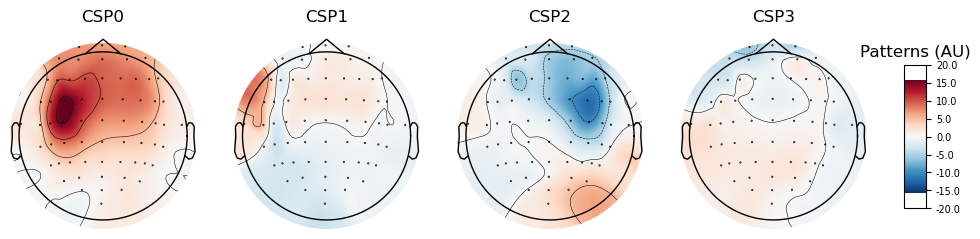

In [133]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)


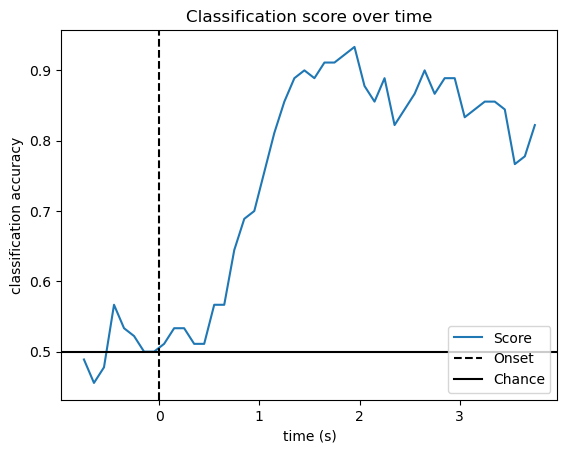

In [134]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [122]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.naive_bayes import MultinomialNB 
mnbc = MultinomialNB()
     
scores_windows = []


In [123]:
del X_train
del y_train
del y_test
del X_test
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

In [124]:

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    mnbc.fit(abs(X_train), y_train)
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(mnbc.score(abs(X_test),y_test))
    scores_windows.append(score_this_window)

    


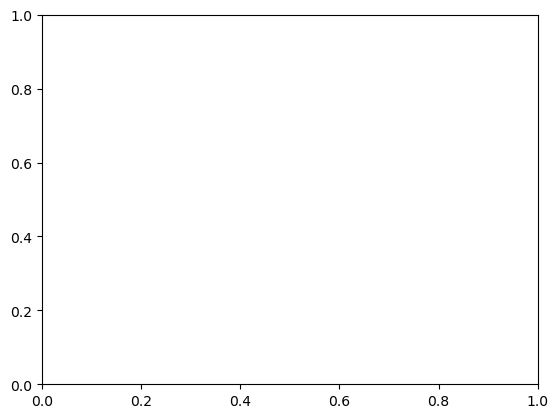

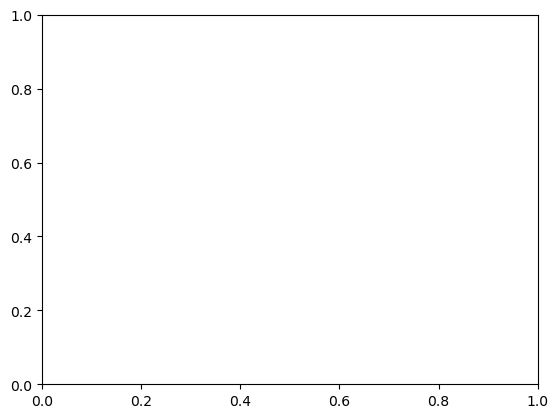

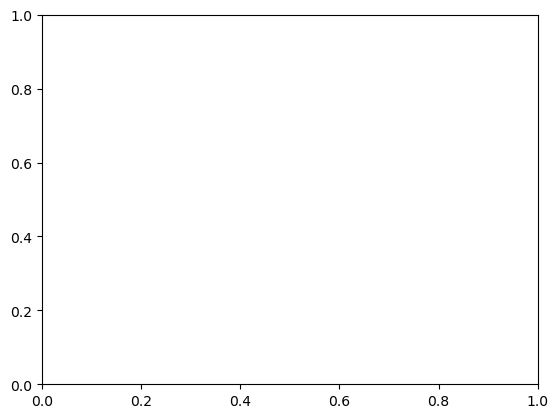

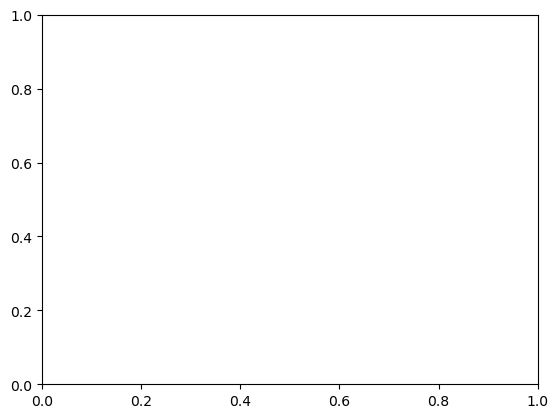

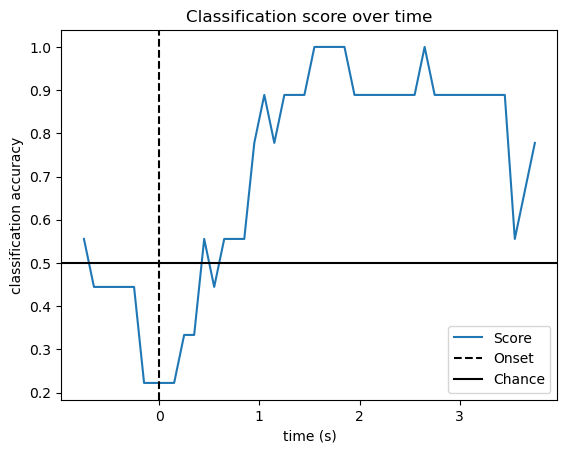

In [130]:
# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [131]:
epochs.to_data_frame()

,time,condition,epoch,FC5,FC3,FC1,FCz,FC2,FC4,FC6,...,P8,PO7,PO3,POz,PO4,PO8,O1,Oz,O2,Iz
0,-1.00000,2,1,23.556691,24.750052,24.425108,28.177470,26.092731,13.942686,8.206183,...,-2.873163,10.116510,13.742015,13.662747,5.753438,-7.843225,30.996585,27.962013,24.826615,39.143499
1,-0.99375,2,1,9.645445,16.598110,15.023042,12.198066,15.965520,13.168716,14.153613,...,3.543416,1.835911,4.686186,7.560426,8.757395,-1.970775,12.472600,12.195288,14.593595,20.808182
2,-0.98750,2,1,3.636517,10.804160,11.834210,3.673855,9.041846,11.459911,13.048490,...,7.148977,4.284140,4.205370,9.138449,12.071827,6.076129,-0.363528,1.040143,3.367973,-5.766984
3,-0.98125,2,1,8.968646,10.128594,12.457161,7.860223,12.773347,13.790268,13.098988,...,11.083940,9.128377,8.568194,14.235920,16.536571,20.592886,1.579964,6.109927,2.866379,-10.317688
4,-0.97500,2,1,17.863315,15.677695,15.986557,19.962697,21.250568,20.995850,19.764190,...,19.076032,12.470911,11.217592,14.570234,21.907432,35.932129,12.025276,21.197886,21.343890,7.812712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36040,3.97500,2,89,31.675324,10.910336,-2.991551,-7.676448,-16.738354,-22.578771,-17.594266,...,38.252418,66.016274,60.846985,38.141849,35.202842,43.590015,72.571458,56.540019,50.159658,61.369872
36041,3.98125,2,89,30.723471,15.993143,9.009094,9.311918,11.165960,15.165976,23.013937,...,42.826286,56.280988,53.676046,47.727878,50.337078,60.450961,65.547115,58.718152,69.734114,88.987554
36042,3.98750,2,89,38.701158,29.257650,30.070044,36.155824,46.864615,53.907410,54.790272,...,39.376188,51.956489,49.619739,53.329877,55.895787,63.103363,56.352683,66.176290,86.175009,103.480734
36043,3.99375,2,89,51.883491,41.549923,41.169144,44.171321,54.992144,58.402592,48.497952,...,26.323710,29.290773,26.470289,29.606142,32.864364,33.097642,42.059902,59.071329,74.431291,81.004352
